**NOMS I COGNOMS:** Zhipeng Lin, Zhihan Lin

**GRUP DE LABORATORI:** A

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [1]:
#Install lib

In [2]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [3]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Variables globals
YEARS = [2019, 2020, 2021]

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [5]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [6]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [7]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

minimal_distance = 0.5 #equival 500 meters
maximal_distance = 50 #equival 50 km
minimal_passenger_count = 1
maximal_passenger_count = 9


def clean_data(data, year, month, sampling = 1000):
    """
    Funció que neteja les dades per un mes donat.
    """
    # AQUÍ EL TEU CODI
    data = data[::sampling]
    filt1 = (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime'])
    filt2 = (pd.DatetimeIndex(data['tpep_pickup_datetime']).year == year)
    filt3 = (data['passenger_count'] >= minimal_passenger_count)
    filt4 = (data['passenger_count'] <= maximal_passenger_count)
    filt5 = (data['trip_distance'] >= minimal_distance)
    filt6 = (data['total_amount'] > 0) 

    data = data.loc[filt1 & filt2 & filt3 & filt4 & filt5 & filt6]
    
    return(data[required_data].drop_duplicates())   
    
    

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [8]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # AQUÍ EL TEU CODI
    
    #Quantitat de viatges de cada any.
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year

    data['pickup_hour'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).hour
    data['pickup_day'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).dayofweek
    data['pickup_week'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).weekofyear
    data['pickup_month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month

    data['dropoff_hour'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).hour
    data['dropoff_day'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).dayofweek
    data['dropoff_week'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).weekofyear
    data['dropoff_month'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).month   

    data['trip_duration'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']) - pd.DatetimeIndex(data['tpep_pickup_datetime'])

       
    return data 

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [9]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
df.loc[df['passenger_count'].isnull()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount


In [11]:
df = post_processing(df)
df.shape

C:\Users\zhipe\AppData\Local\Temp\ipykernel_3844\1727461428.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['pickup_week'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).weekofyear
C:\Users\zhipe\AppData\Local\Temp\ipykernel_3844\1727461428.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['dropoff_week'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).weekofyear


(127318, 19)

In [12]:
df.head(1)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40


## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [13]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    dg = df[column].value_counts()
    dg = dg.sort_index()
    dg.plot.bar(xlabel =xlabel, ylabel = ylabel, rot=0, title=title)

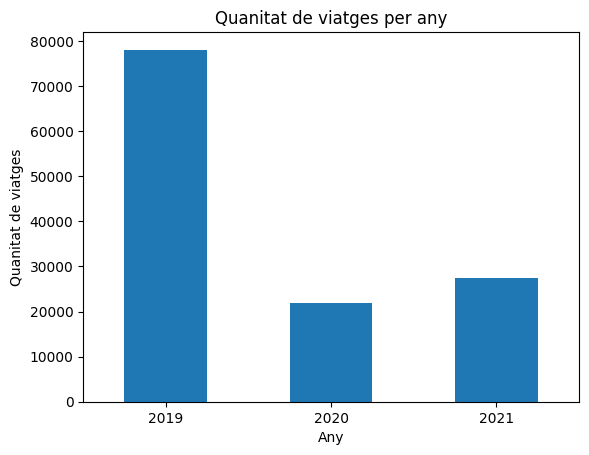

In [14]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

In [15]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0,1,1,1,1,1,1,1,0 days 00:08:07
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0,1,1,1,1,1,1,1,0 days 00:29:22
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0,1,1,1,1,1,1,1,0 days 00:08:27
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0,1,1,1,0,1,1,1,0 days 00:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107000,2021-12-31 22:02:53,2022-01-01 21:23:40,1.0,1.05,114,234,2,6.0,9.80,2021,22,4,52,12,21,5,52,1,0 days 23:20:47
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80,2021,22,4,52,12,22,4,52,12,0 days 00:09:40
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80,2021,22,4,52,12,23,4,52,12,0 days 00:09:41
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00,2021,23,4,52,12,23,4,52,12,0 days 00:03:28


**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER: Si el comortament és el que esperàvem, amb el Covid, els nombres de passatgers disminueixen.  

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [16]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    # la suma del nombre de passatgers que hi ha cada any
    dg = df[['year','passenger_count']].groupby('year').sum()

    if norm:
        passengers_taxi_year_total = dg['passenger_count'].sum()

        dg['passenger_count'] = dg['passenger_count'] / passengers_taxi_year_total


    dg.plot.bar(xlabel =xlabel, ylabel = ylabel, rot=0, title=title, ylim=ylim)


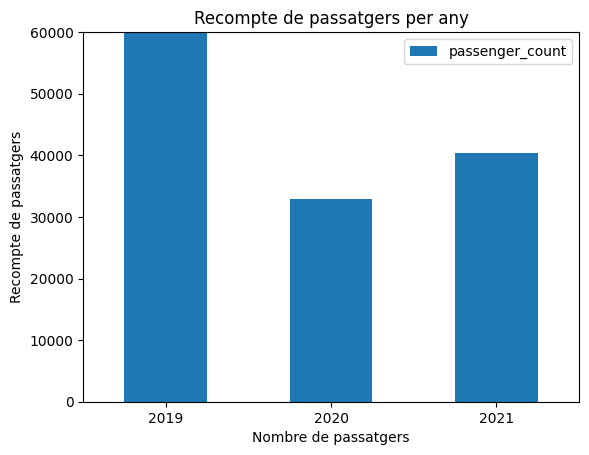

In [17]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

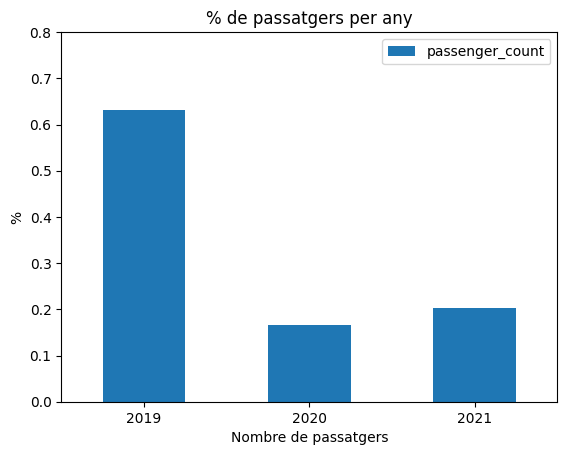

In [18]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers', '%', '% de passatgers per any', norm = True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [19]:
from collections import defaultdict
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """
    dct = defaultdict()
    index = np.sort(df['passenger_count'].unique())
    
    for y in YEARS:
        fit = (df['year']==y)
        dg = df.loc[fit]['passenger_count']
        dg = dg.value_counts().sort_index()
        if norm:
            count = dg.sum()
            dg = dg/count
        dct[f'{y}'] = dg.to_list()

    dg = pd.DataFrame(dct,index=index)
    dg.plot.bar(rot=0)

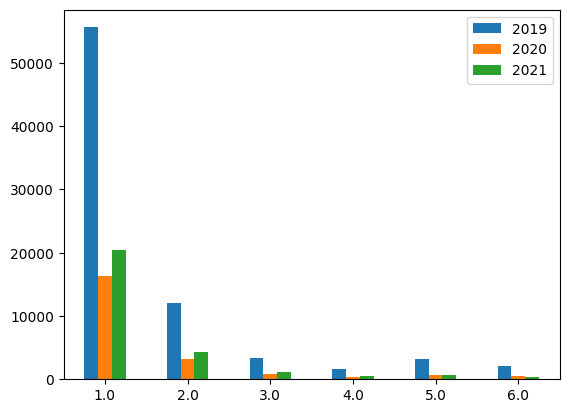

In [20]:
passengers_taxi(df, 'Passenger Count', 'Amount')

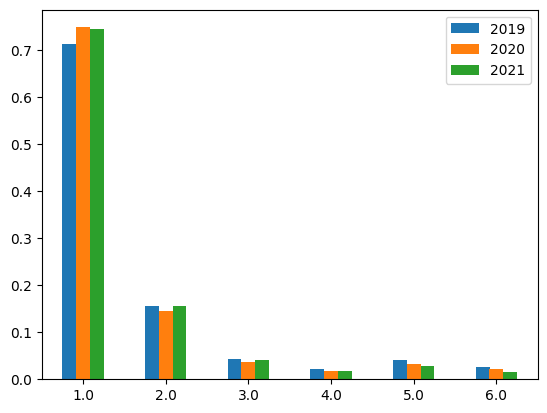

In [21]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm = True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER => Els passatgers en taxi a Nova York han baixat significativament a causa del Covid, el nombre de passatgers comptades el 2019 és practicament el doble que la suma dels passatgers del 2020 i el 2021 .

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [22]:
from collections import defaultdict
def visualize_trips(columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    #pickup_dg = df[columns[0]].value_counts()
    #dropoff_dg = df[columns[1]].value_counts()

    #dg = pd.concat([pickup_dg, dropoff_dg], axis = 1)

    #dg = dg.sort_index()
    #dg.plot.line(rot=0, style='x:')

    for column in columns:
        #dg = df[columns[0]].value_counts().sort_index()
        index = np.sort(df[column].unique())
        dct = defaultdict()
        for y in YEARS:
            lista = df.loc[df['year']==y,column].value_counts().sort_index()
            lista = lista.reindex(index)
            lista = lista.to_list()
            dct[f'{y}'] = lista
        dg = pd.DataFrame(dct,index=index)
        dg.plot.line(rot=0, style='x:', title=column)
            


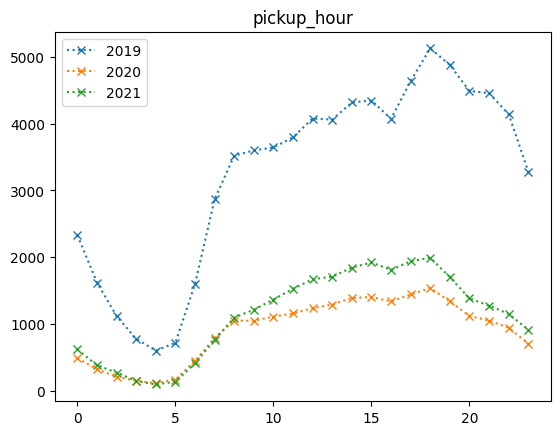

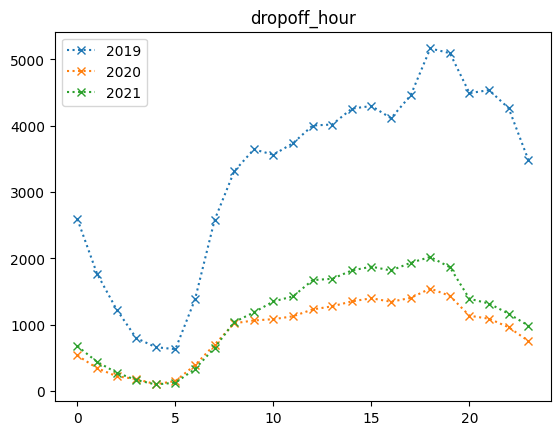

In [23]:
visualize_trips(['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

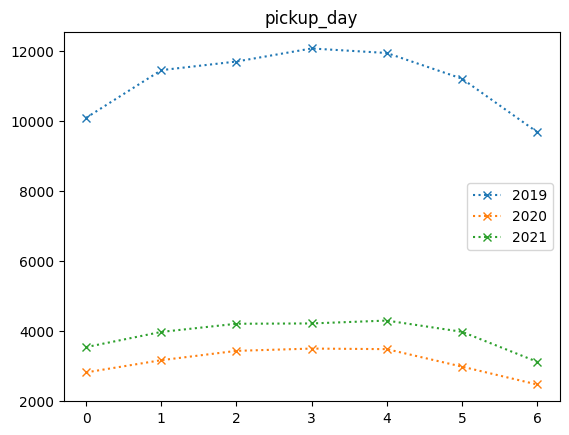

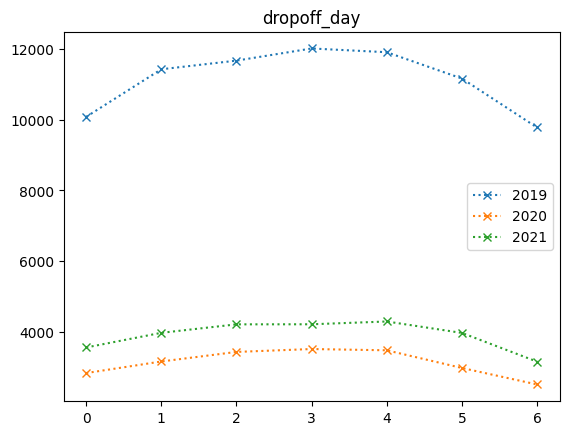

In [24]:
visualize_trips(['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

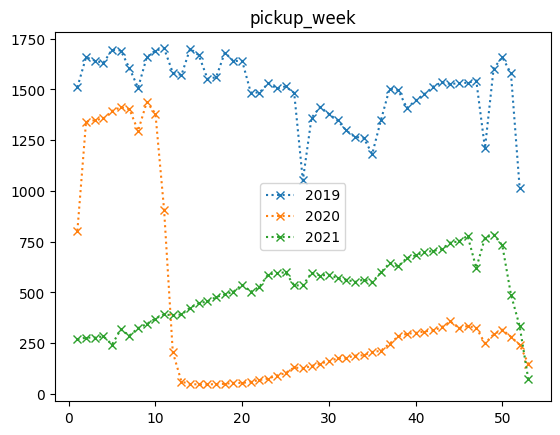

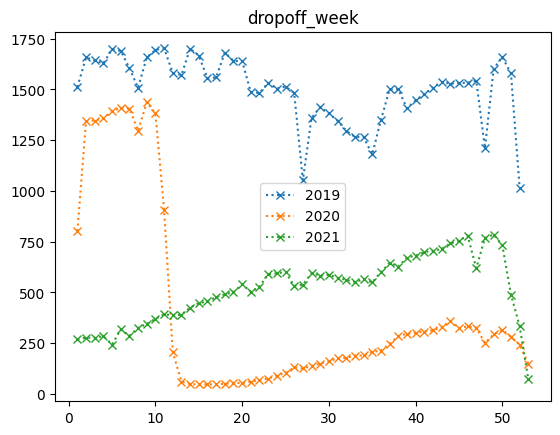

In [25]:
visualize_trips(['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

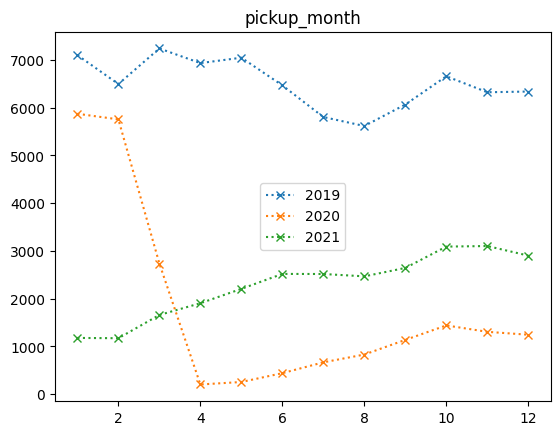

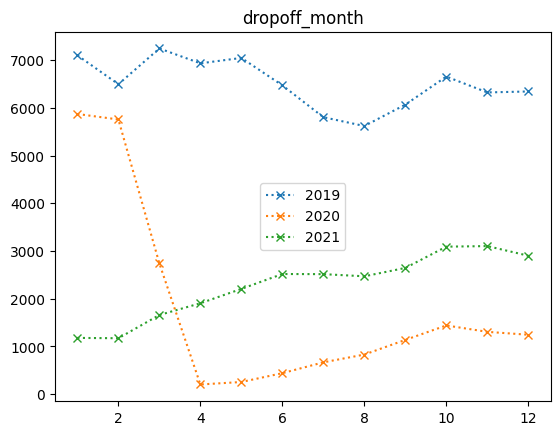

In [26]:
visualize_trips(['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER
:   La comportament que veiem:
- Per hora: hi ha més quantitat de viatges en el migdia, ja que de bon matí o en la nit no hi ha tanta gent despertada.
- Per dia de la setmana: hi ha més quantitat de viatges en dimecres i dijous i molt menys quantitat de viatges en cap de la setmana perquè la gent descansen.
- Per setmana de l'any: hi ha més quantitat de viatges en el principi de l'any i es van disminuint fins que en els ultimes setmanes de l'any la quantitat de viatges es la més petita, perquè crec és quan produeix la pandèmia.
- Per mes de l'any: hi ha més quantitat de viatges en el principi de l'any, però després es va disminuir molt acausa del covid.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [27]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0,1,1,1,1,1,1,1,0 days 00:08:07
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0,1,1,1,1,1,1,1,0 days 00:29:22
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0,1,1,1,1,1,1,1,0 days 00:08:27
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0,1,1,1,0,1,1,1,0 days 00:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107000,2021-12-31 22:02:53,2022-01-01 21:23:40,1.0,1.05,114,234,2,6.0,9.80,2021,22,4,52,12,21,5,52,1,0 days 23:20:47
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80,2021,22,4,52,12,22,4,52,12,0 days 00:09:40
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80,2021,22,4,52,12,23,4,52,12,0 days 00:09:41
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00,2021,23,4,52,12,23,4,52,12,0 days 00:03:28


In [28]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """

    df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['trip_duration'] = df['trip_duration'].astype('timedelta64[s]')/3600

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 8)) 

    for i in YEARS:

        new_df = df.loc[df['year'] == i, column]
        new_df.hist(bins=75, ax=axs[i-2019])
        axs[i-2019].set_title(title + f" ({i})")
        axs[i-2019].set_xlabel(xlabel)
        axs[i-2019].set_ylabel(ylabel)
        axs[i-2019].set_xlim(xlim)
    
    plt.show()



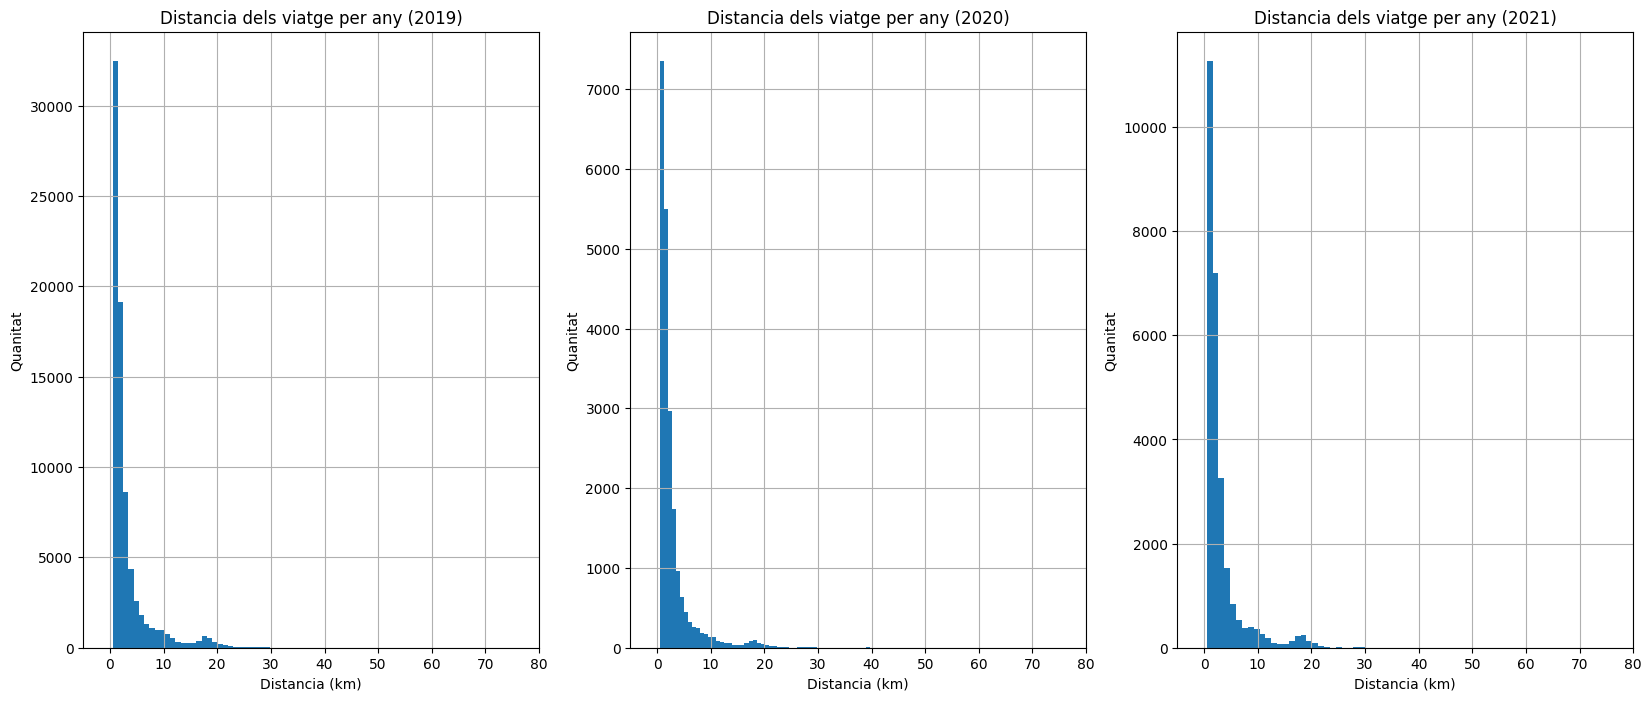

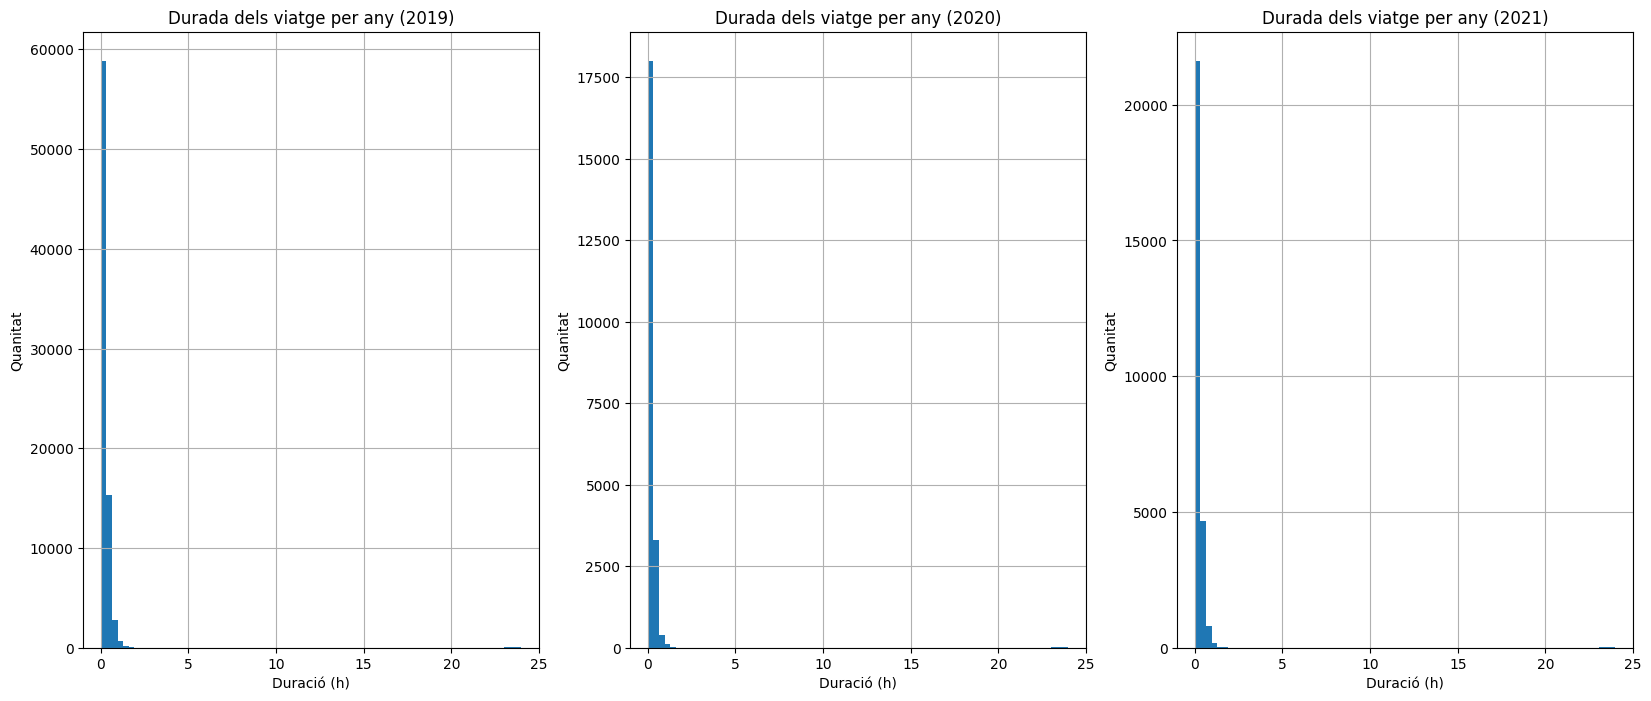

In [29]:
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any', 
                     xlabel = 'Distancia (km)', ylabel = 'Quanitat', xlim = (-5, 80))

visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (h)', ylabel = 'Quanitat', xlim = (-1, 25) )

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER:  Podem veure que en els viatges de curta durada la covid no s'afecta gaire, en canvi, en les viatges de distància mitjana la covid fa que el nombre de viatges es disminueixen. En en cas de durades del viatges passa el mateix, no es veu l'afectació del covid en curta durada sinó afecta més en
llargues durades.

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [30]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [31]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)')

NotImplementedError: 

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [ ]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [ ]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.60,239,246,1,14.0,16.30,2019,0,1,1,1,1,1,1,1,0 days 00:19:12
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.30,163,229,1,6.5,9.05,2019,0,1,1,1,0,1,1,1,0 days 00:07:09
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.70,229,7,1,13.5,18.50,2019,0,1,1,1,0,1,1,1,0 days 00:13:38
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.10,141,234,1,10.0,13.00,2019,0,1,1,1,1,1,1,1,0 days 00:12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,2021-12-01 07:45:25,2021-12-01 08:19:17,2.0,9.38,138,163,1,31.0,38.55,2021,7,2,48,12,8,2,48,12,0 days 00:33:52
10691,2021-12-01 07:37:21,2021-12-01 07:53:50,3.0,3.30,231,230,1,13.5,18.80,2021,7,2,48,12,7,2,48,12,0 days 00:16:29
10692,2021-12-01 07:35:05,2021-12-01 08:01:14,1.0,3.79,238,140,1,18.5,23.98,2021,7,2,48,12,8,2,48,12,0 days 00:26:09
10693,2021-12-01 07:51:59,2021-12-01 08:46:01,1.0,12.15,138,231,1,41.5,65.44,2021,7,2,48,12,8,2,48,12,0 days 00:54:02


In [ ]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [ ]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,239,246,1,14.0,16.30,2019,0,1,1,1,1,1,1,1,0 days 00:19:12
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,163,229,1,6.5,9.05,2019,0,1,1,1,0,1,1,1,0 days 00:07:09
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,229,7,1,13.5,18.50,2019,0,1,1,1,0,1,1,1,0 days 00:13:38
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,141,234,1,10.0,13.00,2019,0,1,1,1,1,1,1,1,0 days 00:12:00


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [ ]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [ ]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [ ]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


c:\Users\zhiha\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


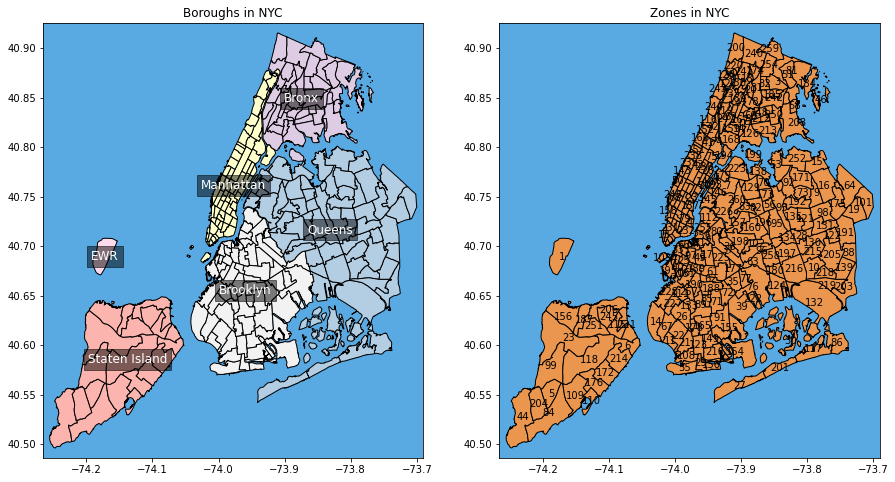

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [ ]:
# AQUÍ EL TEU CODI

merge = pd.merge(df,df_loc, left_on='PULocationID', right_on='LocationID')

In [ ]:
merge.shape

(357299, 27)

## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [ ]:
merge.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_month,trip_duration,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,...,1,0 days 00:06:40,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
1,2019-01-01 00:52:37,2019-01-01 01:03:42,1.0,2.10,151,142,2,9.5,10.80,2019,...,1,0 days 00:11:05,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
2,2019-01-01 00:15:02,2019-01-01 00:22:33,4.0,1.50,151,142,2,8.0,9.30,2019,...,1,0 days 00:07:31,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
3,2019-01-01 00:44:29,2019-01-01 00:51:23,3.0,0.83,151,238,1,6.5,8.58,2019,...,1,0 days 00:06:54,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859
4,2019-01-01 00:54:30,2019-01-01 01:09:16,1.0,4.73,151,243,2,16.0,17.30,2019,...,1,0 days 00:14:46,151,0.05489,0.000129,Manhattan Valley,151,Manhattan,-73.968222,40.797859


In [ ]:
# Recollida
# AQUÍ EL TEU CODI
top_pu = merge[['year','zone','passenger_count']].groupby(['year','zone']).count()['passenger_count'].groupby('year', group_keys=False)
#top_pu = merge[['year','zone','PULocationID']].groupby(['year','zone']).count().sort_values('PULocationID',ascending=False)
#print(top_pu)


# Destí
# AQUÍ EL TEU CODI
top_do = ...

In [ ]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # AQUÍ EL TEU CODI
    print(df.nlargest(n_top))
    #df = df[column].groupby('year',group_keys=False).nlargest(n_top)
    #print(df)

In [ ]:
show_top_n(top_pu, 'PULocationID', df_loc)

year  zone                        
2019  East Village                    6608
      Clinton East                    6361
      JFK Airport                     6351
      Times Sq/Theatre District       5238
      West Village                    4603
2020  Upper East Side North           4729
      Clinton East                    4577
      Penn Station/Madison Sq West    4576
      East Village                    4526
      Upper East Side South           4266
2021  Penn Station/Madison Sq West    6419
      JFK Airport                     5579
      Clinton East                    5430
      East Village                    4982
      Upper East Side North           4608
Name: passenger_count, dtype: int64


In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Visualitzem amb un mapa de calor quines són les zones més recurrents**

In [ ]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

AttributeError: 'ellipsis' object has no attribute 'year'

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [ ]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [ ]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    print(merge)

In [ ]:
scatter_locations(merge, hospitals)

NameError: name 'merge' is not defined

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values


# AQUÍ EL TEU CODI    
dist = ...

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [ ]:
# AQUÍ EL TEU CODI
hospitals_locations = ...
hospitals['LocationID'] = hospitals_locations

In [ ]:
hospitals.head()

Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.